In [1]:
from backbones_unet.model.unet import Unet
from backbones_unet.utils.dataset import SemanticSegmentationDataset
from backbones_unet.model.losses import DiceLoss
from backbones_unet.utils.trainer import Trainer
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
train_img_path='integer-encoded-dataset-Augmented/images/training'
train_mask_path='integer-encoded-dataset-Augmented/masks/training'
val_img_path='integer-encoded-dataset-Augmented/images/validation'
val_mask_path='integer-encoded-dataset-Augmented/masks/validation'


In [3]:
train_dataset=SemanticSegmentationDataset(train_img_path,train_mask_path,mode='multi')
val_dataset=SemanticSegmentationDataset(val_img_path,val_mask_path,mode='multi')

train_loader=DataLoader(train_dataset,batch_size=2)
val_loader=DataLoader(val_dataset,batch_size=2)

In [4]:
model=Unet(
    backbone='mobilenetv2_050',
    in_channels=3,
    num_classes=4
)
params=[p for p in model.parameters() if p.requires_grad]
optimizer=torch.optim.AdamW(params,1e-4)
# optimizer=torch.optim.SGD(params,1e-4)


In [5]:
trainer2=Trainer(model,criterion=DiceLoss(),optimizer=optimizer,epochs=100)
trainer2.fit(train_loader,val_loader)

/home/sukrit/.local/lib/python3.10/site-packages/backbones_unet/utils/trainer.py:132: UserWarning: Device was automatically selected: cuda
  warnings.warn(msg)
Traning Model on 100 epochs: 100%|██████████| 100/100 [25:02<00:00, 15.03s/it]


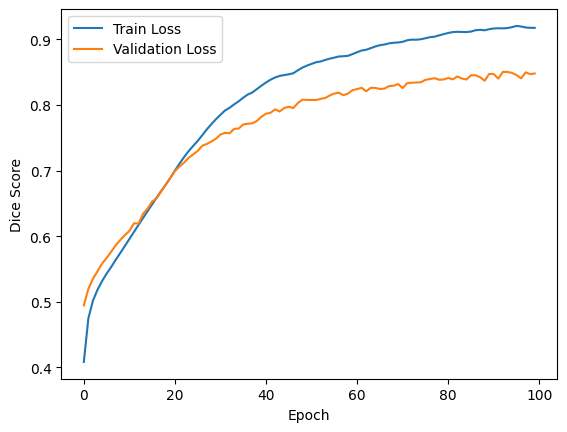

In [7]:
plt.plot(1-trainer2.train_losses_,label='Train Loss')
plt.plot(1-trainer2.val_losses_,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

In [8]:
images_test_dir_path = "integer-encoded-dataset-Augmented/images/test"
masks_test_dir_path = "integer-encoded-dataset-Augmented/masks/test" 
evaluation_save_dir_path = "outputs/resnet50/" 

images_in_test=[images_test_dir_path+'/'+i for i in os.listdir(images_test_dir_path)] 
masks_in_test=[masks_test_dir_path+'/'+i for i in os.listdir(masks_test_dir_path)]

images_in_test=sorted(images_in_test,key=lambda x: int(x.split('_')[2].split('.')[0]))
masks_in_test=sorted(masks_in_test,key=lambda x: int(x.split('_')[2].split('.')[0]))


testing:   0%|          | 0/9 [00:00<?, ? testing-batch/s]

True Cellularity=78.162%	Predicted Cellularity=83.416%	Accuracy of Cellularity prediction=94.75%


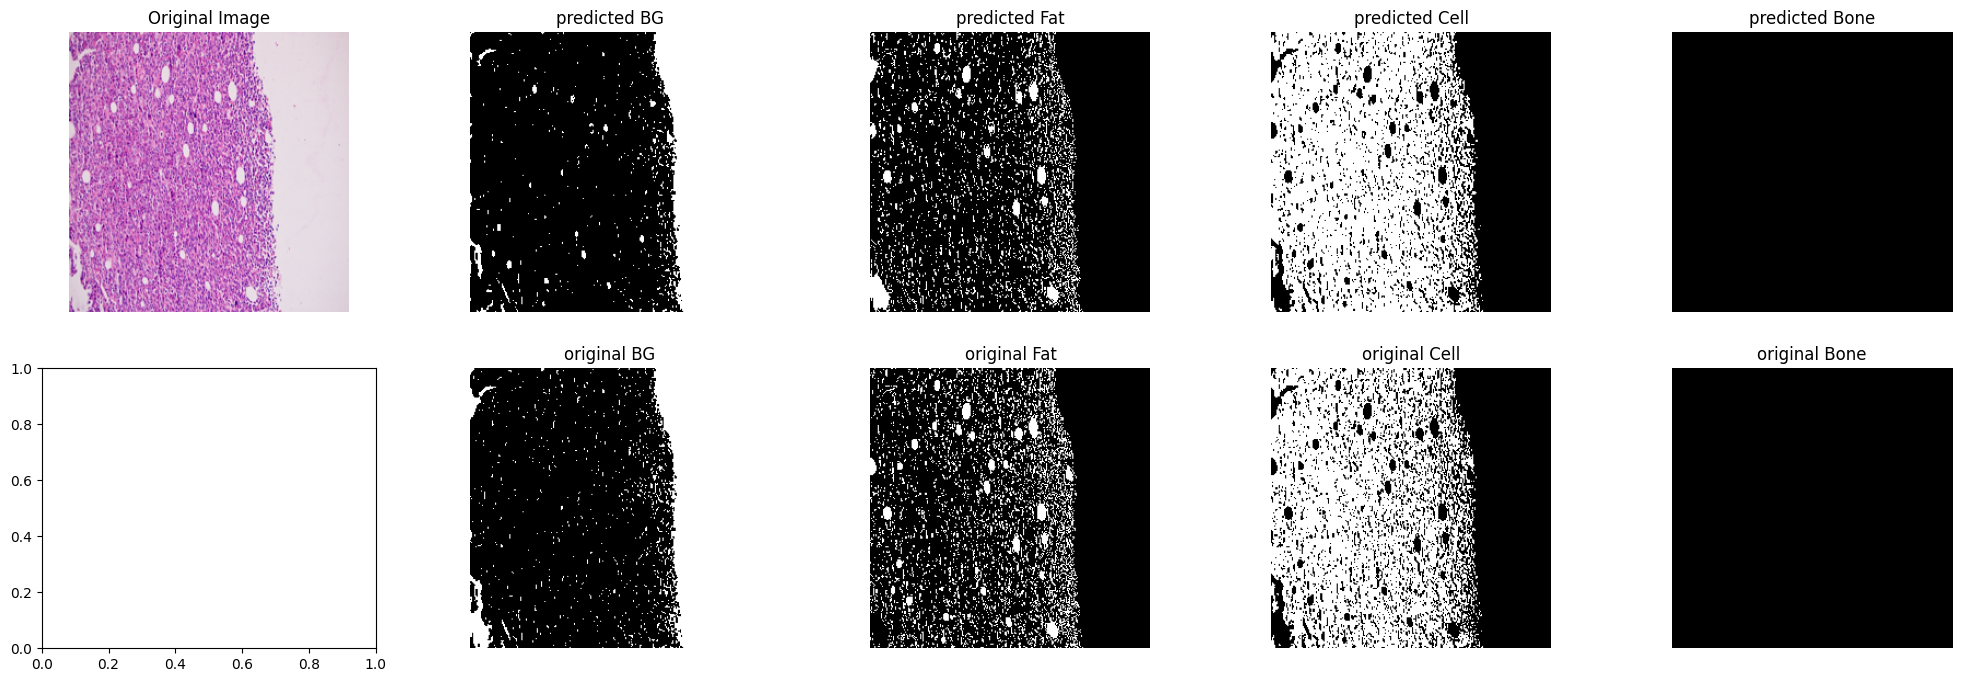

testing:  11%|█         | 1/9 [00:01<00:07,  1.02 testing-batch/s]

True Cellularity=84.494%	Predicted Cellularity=87.220%	Accuracy of Cellularity prediction=97.27%


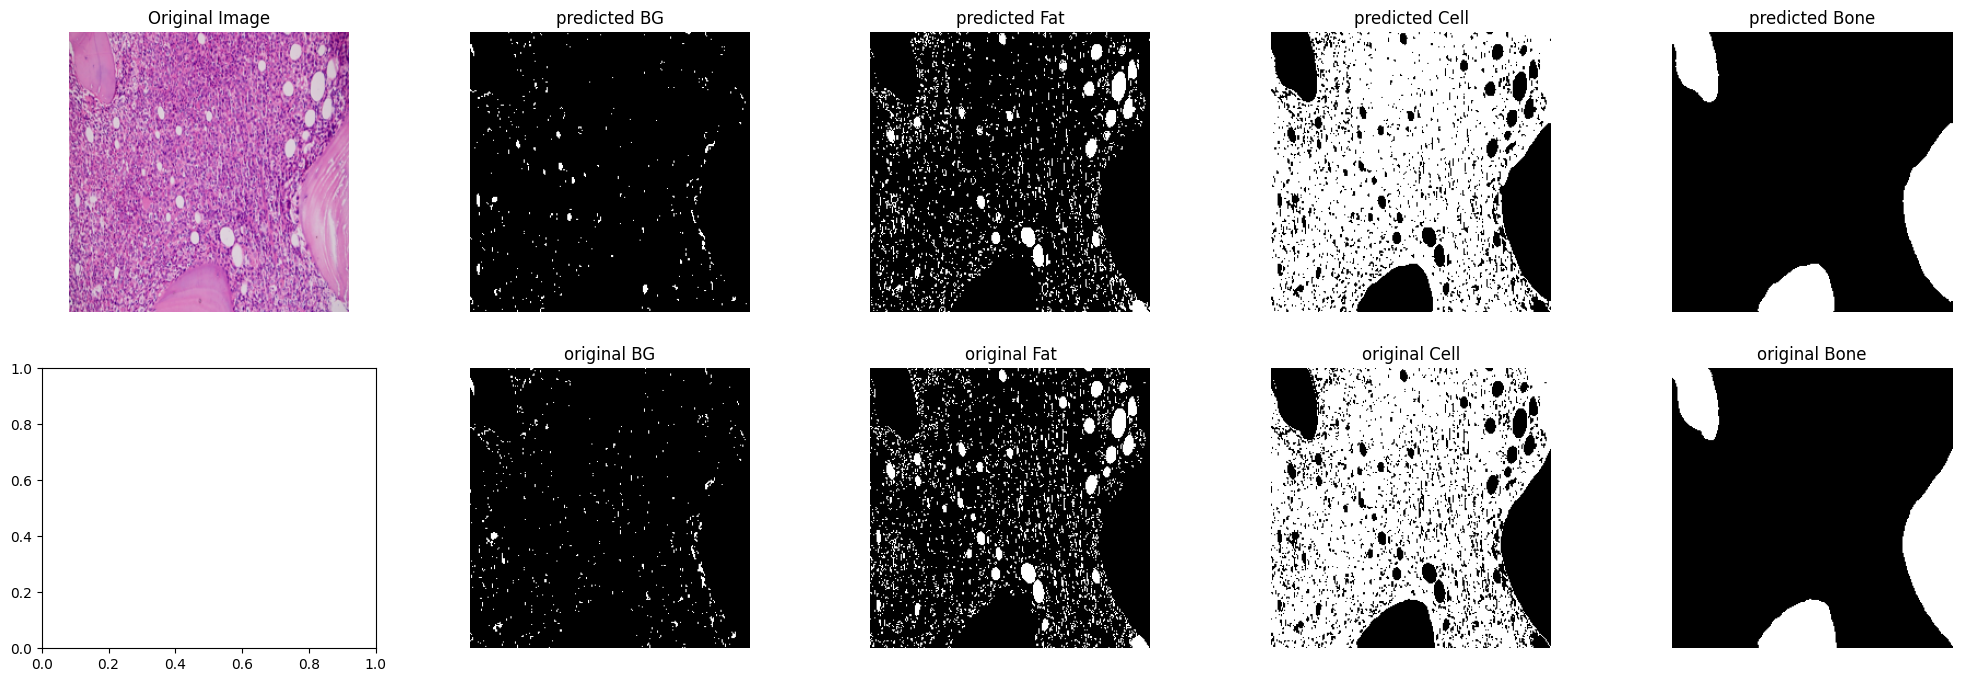

testing:  22%|██▏       | 2/9 [00:01<00:06,  1.07 testing-batch/s]

True Cellularity=28.474%	Predicted Cellularity=27.934%	Accuracy of Cellularity prediction=99.46%


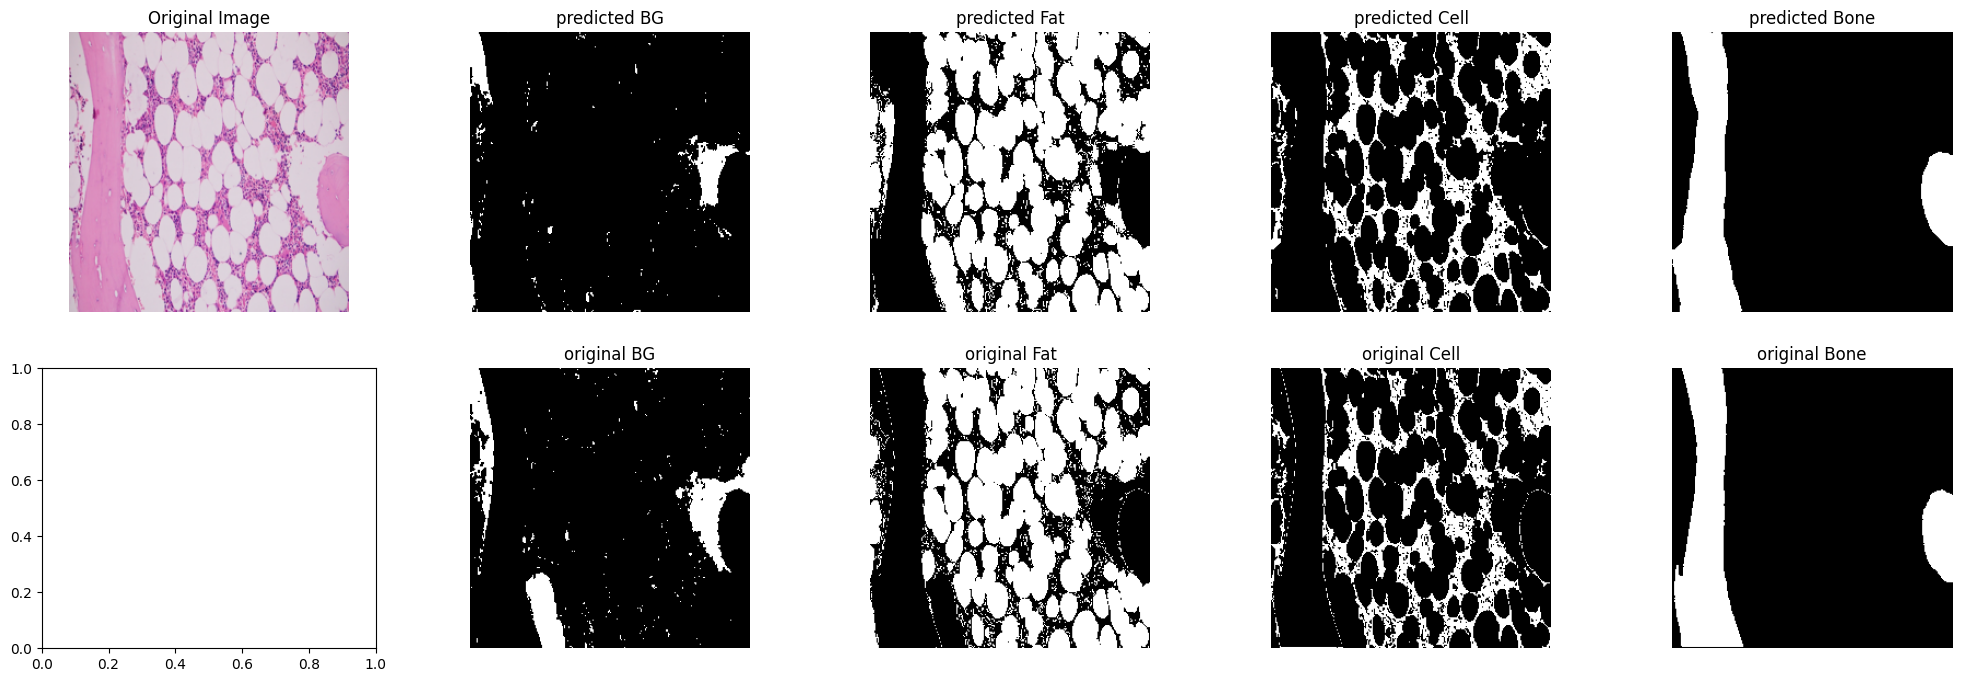

testing:  33%|███▎      | 3/9 [00:02<00:05,  1.10 testing-batch/s]

True Cellularity=17.616%	Predicted Cellularity=20.171%	Accuracy of Cellularity prediction=97.44%


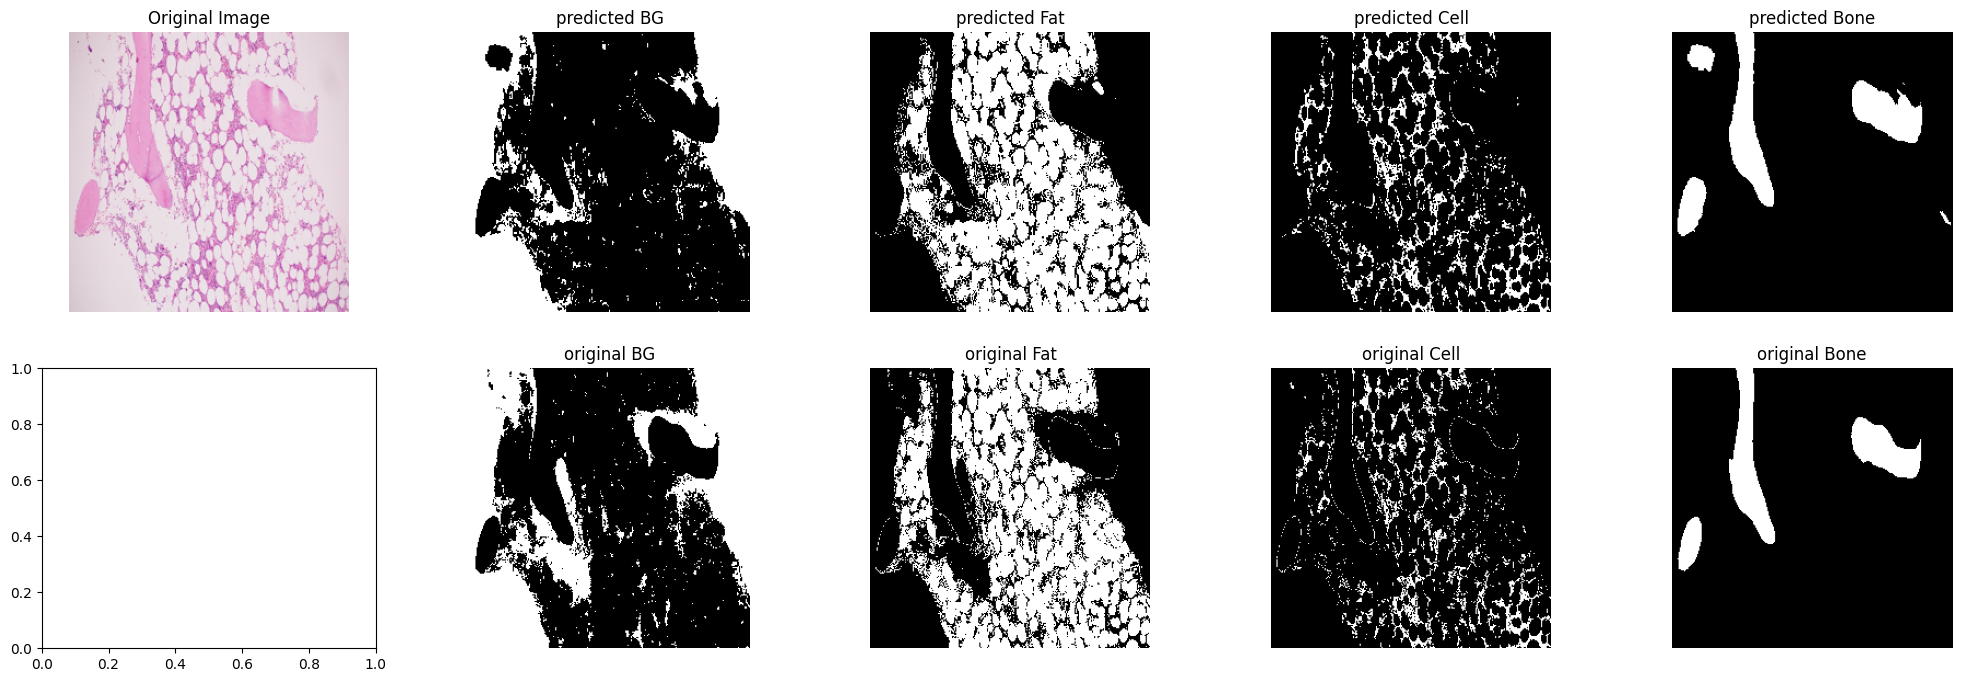

testing:  44%|████▍     | 4/9 [00:03<00:04,  1.12 testing-batch/s]

True Cellularity=35.879%	Predicted Cellularity=35.231%	Accuracy of Cellularity prediction=99.35%


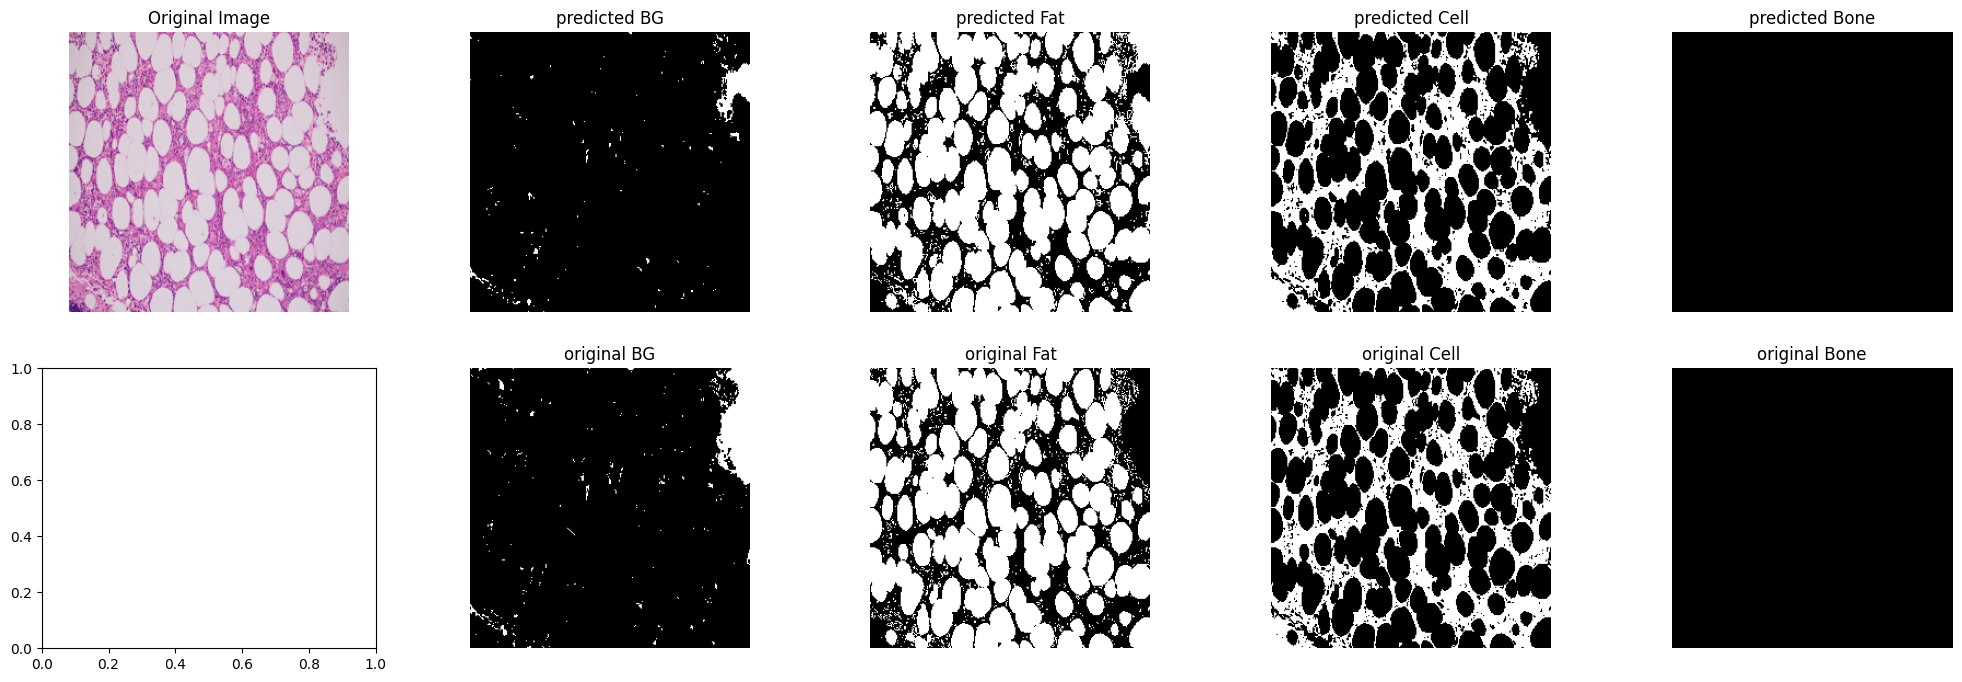

testing:  56%|█████▌    | 5/9 [00:04<00:03,  1.07 testing-batch/s]

True Cellularity=98.941%	Predicted Cellularity=92.757%	Accuracy of Cellularity prediction=93.82%


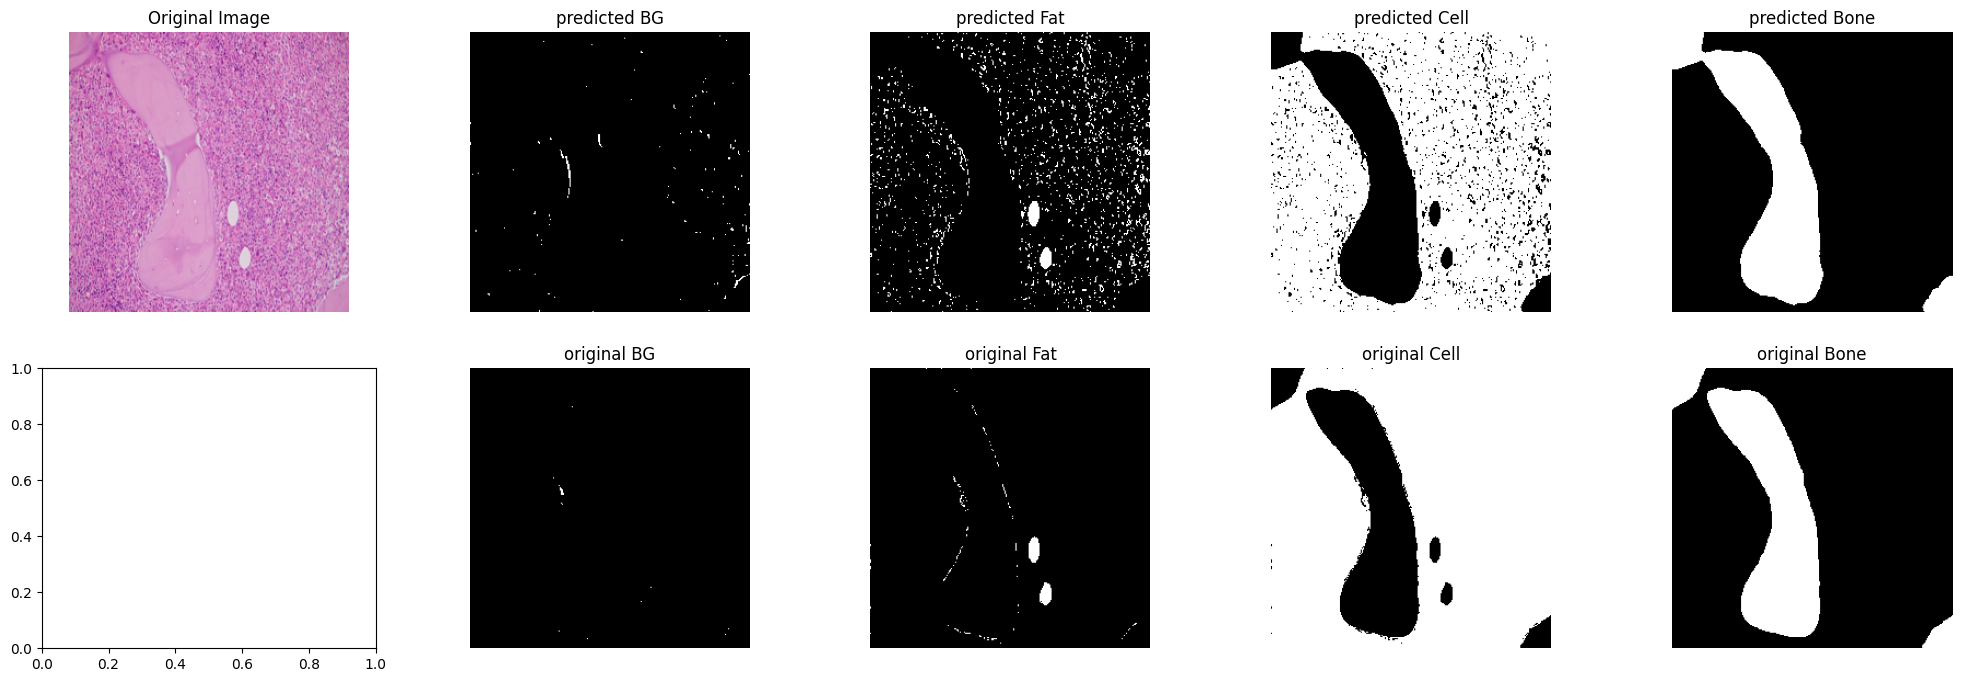

testing:  67%|██████▋   | 6/9 [00:05<00:02,  1.10 testing-batch/s]

True Cellularity=67.147%	Predicted Cellularity=52.020%	Accuracy of Cellularity prediction=84.87%


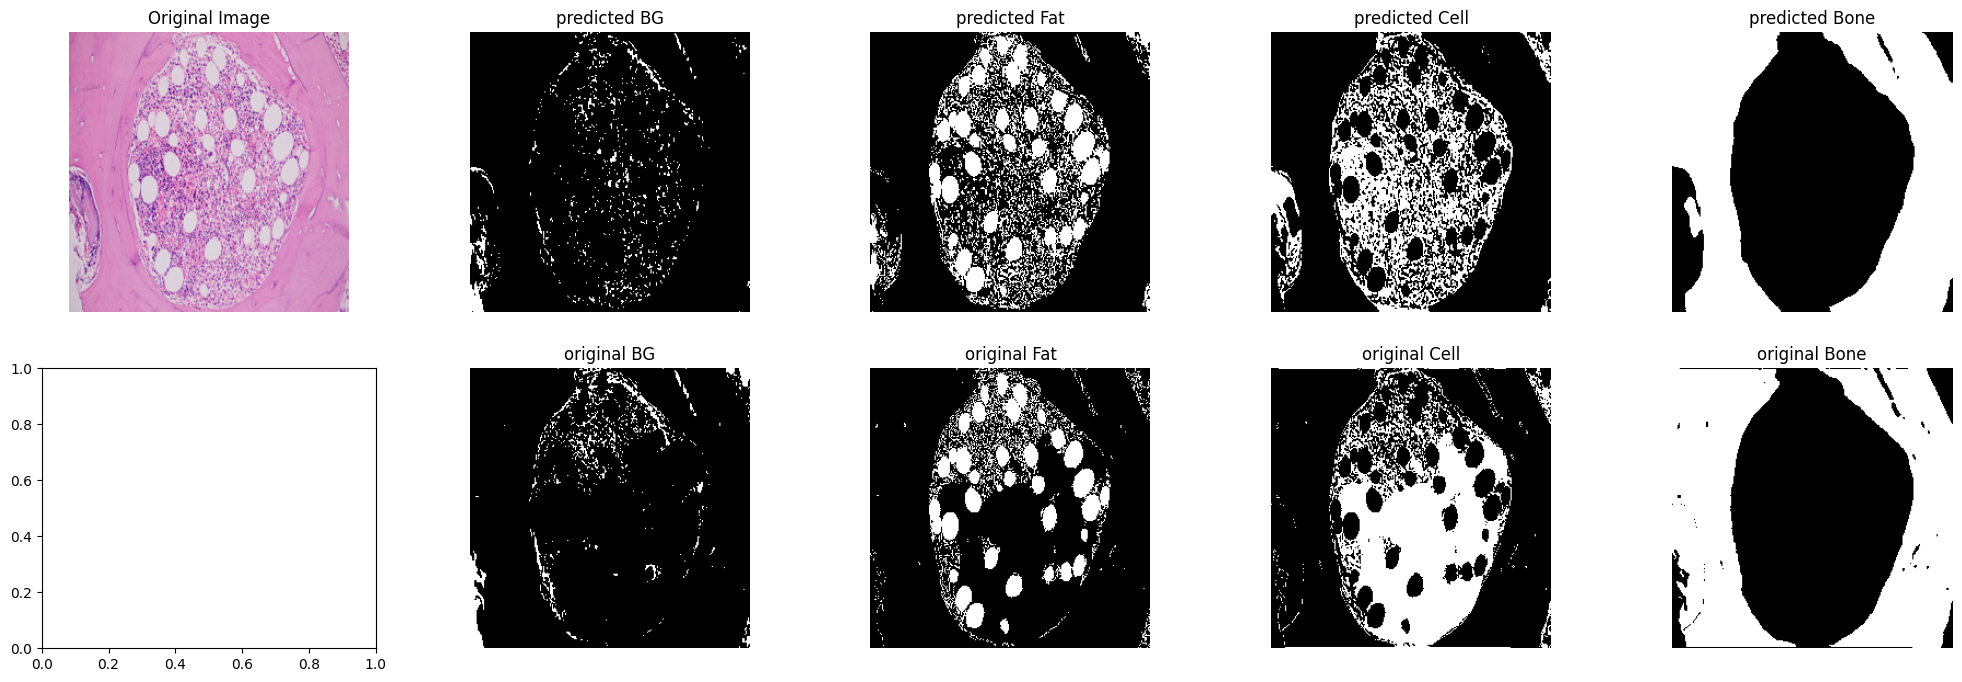

testing:  78%|███████▊  | 7/9 [00:06<00:01,  1.11 testing-batch/s]

True Cellularity=32.773%	Predicted Cellularity=33.687%	Accuracy of Cellularity prediction=99.09%


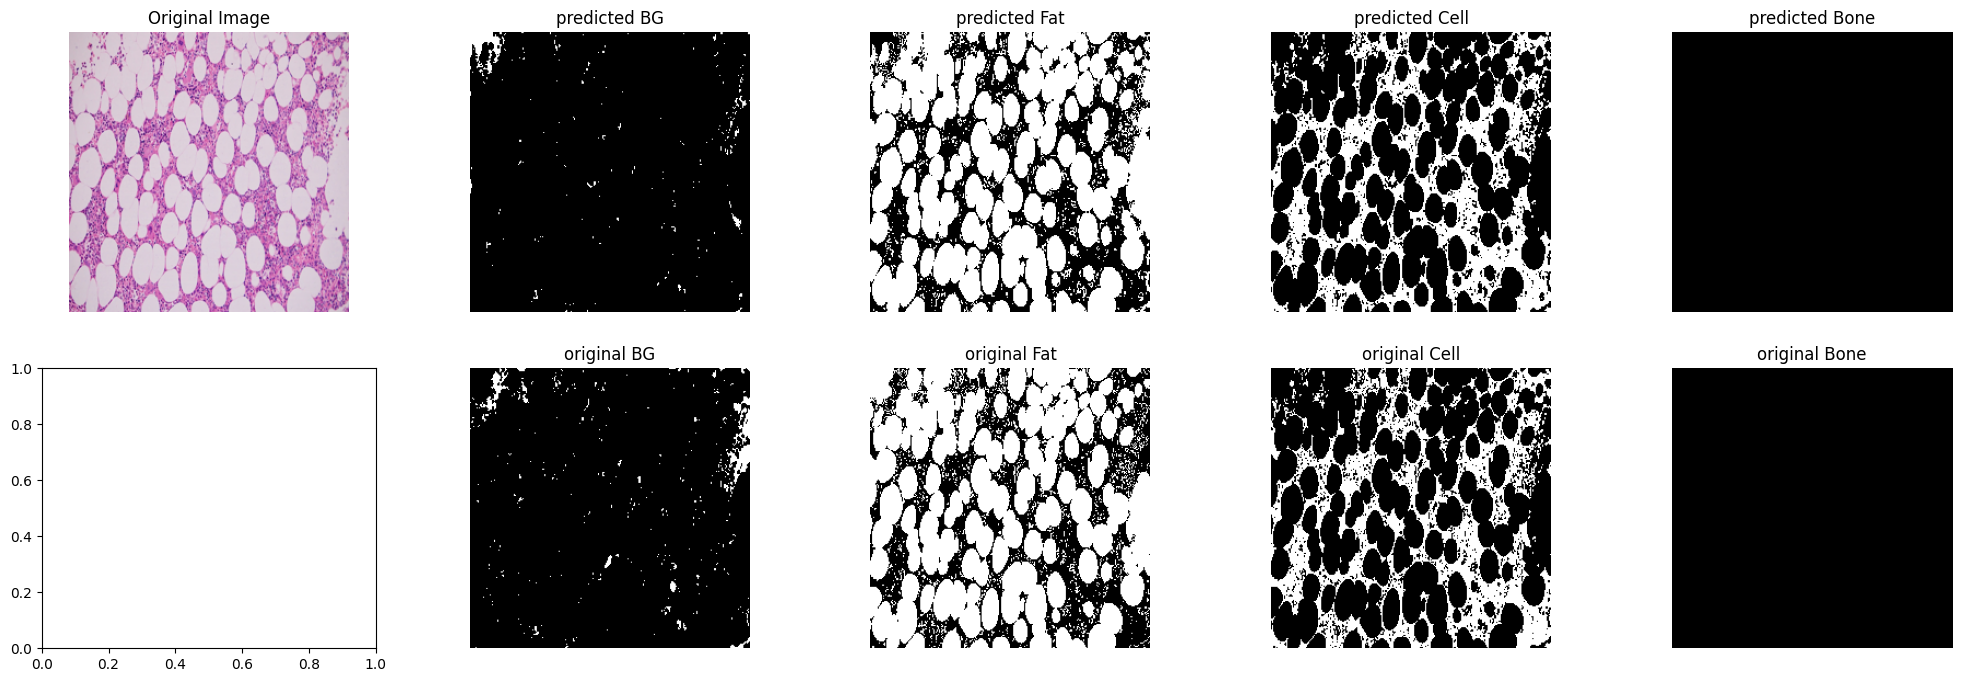

testing:  89%|████████▉ | 8/9 [00:07<00:00,  1.12 testing-batch/s]

True Cellularity=44.332%	Predicted Cellularity=45.703%	Accuracy of Cellularity prediction=98.63%


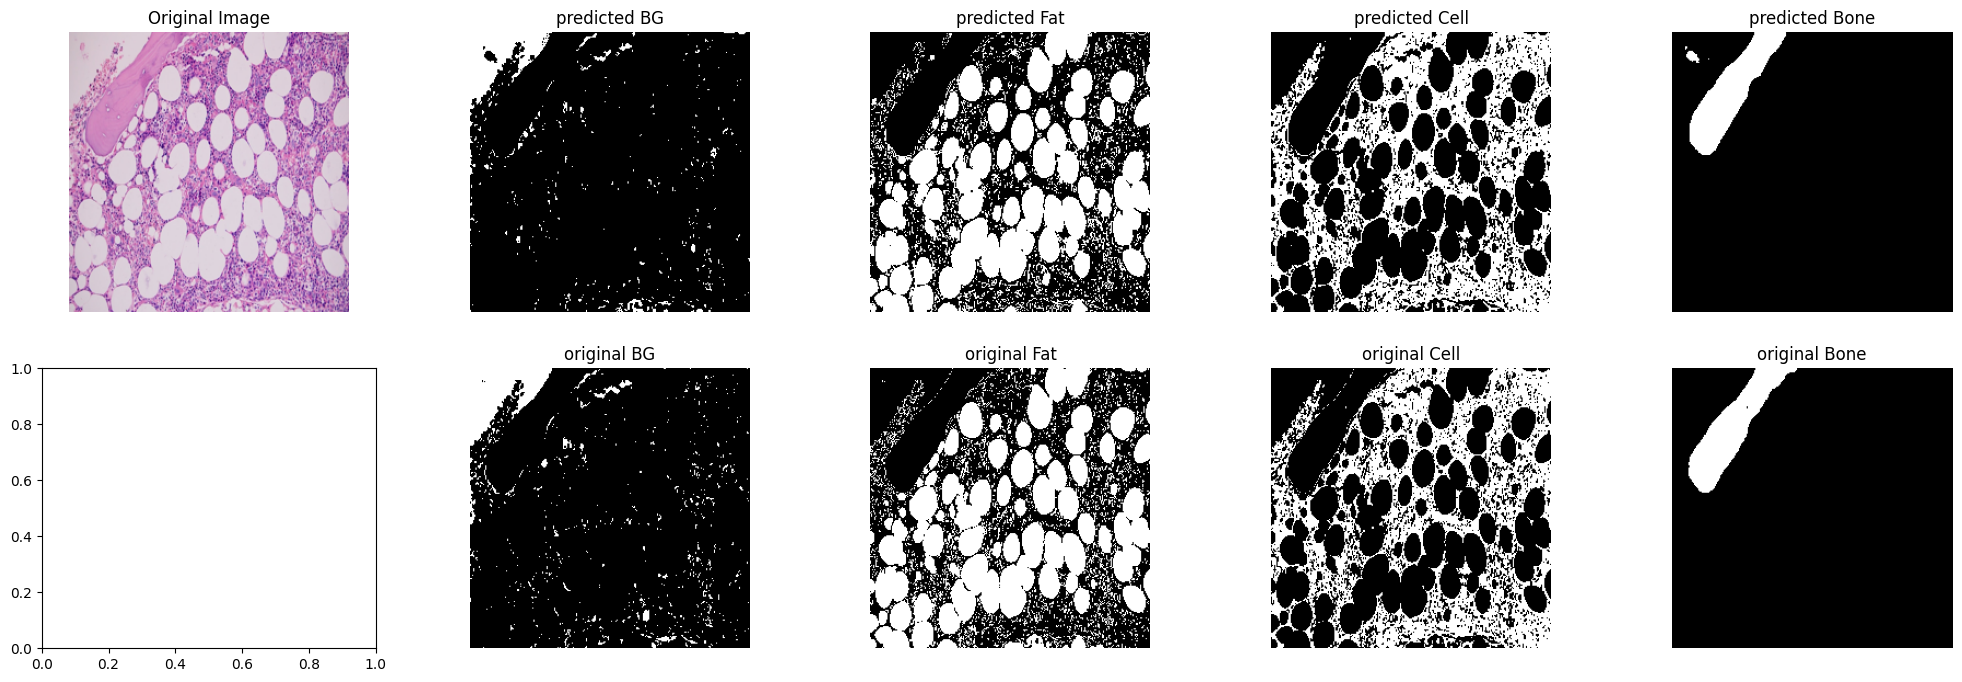

testing: 100%|██████████| 9/9 [00:08<00:00,  1.09 testing-batch/s]


In [9]:

testDataset=SemanticSegmentationDataset(images_test_dir_path,None)
test_loader=DataLoader(testDataset,batch_size=1)
 

fat_pred=cell_pred=fat_true=cell_true=0
total_cellularity_prediction_accuracy=0

name_mask={
      0:"BG",
      1:"Fat",
      2:"Cell",
      3:"Bone"
}


with tqdm(test_loader, unit=" testing-batch", colour="green") as evaluation:   
            for i, images in enumerate(evaluation):
                  
                fig,axs=plt.subplots(2,5,figsize=(25,8))

                original_image = Image.open(images_in_test[i]).resize((256,256))
                axs[0][0].imshow(original_image)
                axs[0][0].axis('off')
                axs[0][0].set_title("Original Image")
                
                evaluation.set_description(f"testing")
                images = images.to(torch.device('cuda'))
                model.eval()
                with torch.no_grad():
                    prediction = model.predict(images)
                    
                
                images_cpu = prediction.to(torch.device('cpu'))
                img=images_cpu[0] 
                pred_img=img.numpy()
                pred_img_mask_indices=np.argmax(pred_img,axis=0)
                pred_img_mask=[pred_img_mask_indices==i for i in range(pred_img.shape[0])]
                pred_img_mask=[mask.astype(float) for mask in pred_img_mask]

                fat_pred=np.sum(pred_img_mask[1])
                cell_pred=np.sum(pred_img_mask[2])

                for j in range(4):  
                    axs[0][j+1].imshow(pred_img_mask[j],cmap='gray') 
                    axs[0][j+1].set_title(f"predicted {name_mask[j]}")
                    axs[0][j+1].axis('off')

                original_mask = Image.open(masks_in_test[i]).resize((256,256))
                original_mask_np=np.array(original_mask)
                original_masks=[(original_mask_np==i) for i in range(4)]
                
                fat_true=np.sum(original_masks[1])
                cell_true=np.sum(original_masks[2])

                for j,mask in enumerate(original_masks):  
                    axs[1][j+1].imshow(mask,cmap='gray')
                    axs[1][j+1].set_title(f"original {name_mask[j]}")
                    axs[1][j+1].axis('off')

                cellularity_true=(cell_true*100)/(cell_true+fat_true)
                cellularity_pred=(cell_pred*100)/(cell_pred+fat_pred)
                cellularity_pred_accuracy=(1-abs(cellularity_pred- cellularity_true)/100)*100
                total_cellularity_prediction_accuracy+=cellularity_pred_accuracy
                
                print(f"True Cellularity={cellularity_true:.3f}%\tPredicted Cellularity={cellularity_pred:.3f}%\tAccuracy of Cellularity prediction={cellularity_pred_accuracy:.2f}%")
                plt.savefig(evaluation_save_dir_path+str(i+1)+"_"+str(cellularity_pred_accuracy)[:5]+".png")
                plt.show()

In [10]:
total_cellularity_prediction_accuracy/=len(masks_in_test)
print(total_cellularity_prediction_accuracy)

96.07564023813785
